<a href="https://colab.research.google.com/github/Jalalbaim/Auto-Encoder/blob/main/AutoEncoder_%2B_Latent_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Encoder for Fashion MNist
***
BAIM Mohamed

In [4]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15841547.21it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268849.88it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5033220.80it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21336242.09it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [7]:
# Accès aux labels pour une image spécifique
label_index = training_data.targets[0]  # Pour obtenir le label de la première image
label_name = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
][label_index]

print("Label index:", label_index)
print("Label name:", label_name)

Label index: tensor(9)
Label name: Ankle boot


In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Auto-encoder Class

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

model = Autoencoder(28*28, 16).to(device)

In [14]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        X = X.view(-1, 28*28)  # Flatten the images
        decoded, _ = model(X)
        loss = loss_fn(decoded, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Training Loss: {average_loss:.4f}")


In [16]:
def test(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            X = X.view(-1, 28*28)
            decoded, _ = model(X)
            loss = loss_fn(decoded, X)
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Test Loss: {average_loss:.4f}")


In [17]:
# Parameters
epochs = 10

# Training and Testing
for epoch in range(epochs):
    print("--------------------------")
    print(f"Epoch {epoch+1}")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)


--------------------------
Epoch 1
Training Loss: 0.0265
Test Loss: 0.0181
--------------------------
Epoch 2
Training Loss: 0.0161
Test Loss: 0.0153
--------------------------
Epoch 3
Training Loss: 0.0141
Test Loss: 0.0139
--------------------------
Epoch 4
Training Loss: 0.0132
Test Loss: 0.0130
--------------------------
Epoch 5
Training Loss: 0.0127
Test Loss: 0.0127
--------------------------
Epoch 6
Training Loss: 0.0123
Test Loss: 0.0123
--------------------------
Epoch 7
Training Loss: 0.0120
Test Loss: 0.0121
--------------------------
Epoch 8
Training Loss: 0.0118
Test Loss: 0.0119
--------------------------
Epoch 9
Training Loss: 0.0116
Test Loss: 0.0118
--------------------------
Epoch 10
Training Loss: 0.0115
Test Loss: 0.0118


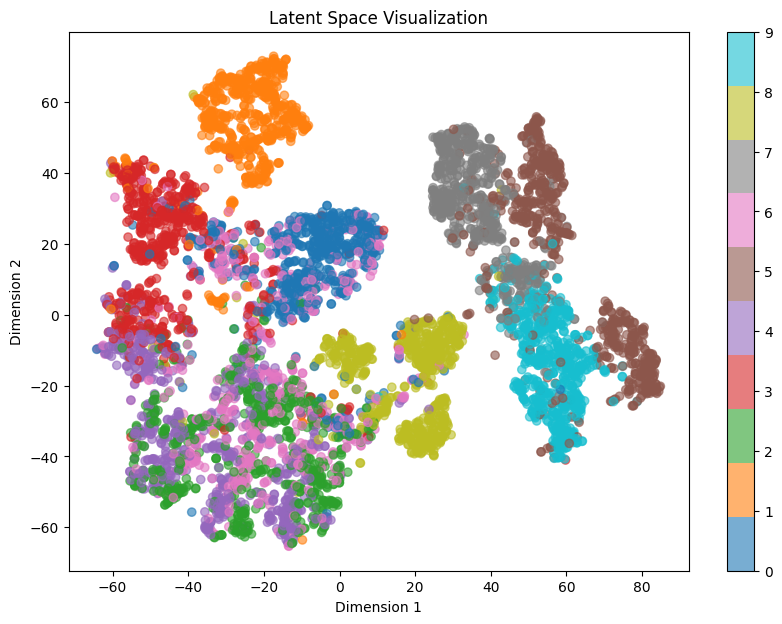

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_latent_space(model, dataloader, num_batches=100):
    model.eval()
    labels = []
    latents = []

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            if i >= num_batches: break
            X = X.to(device)
            X = X.view(-1, 28*28)
            _, latent = model(X)
            latents.append(latent.cpu())
            labels.append(y)

    latents = torch.cat(latents, dim=0)
    labels = torch.cat(labels, dim=0)

    tsne = TSNE(n_components=2, random_state=123)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Latent Space Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Visualize the latent space
visualize_latent_space(model, test_dataloader)
